In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# change this according to your own file location
%cd '/content/drive/MyDrive/Bt4103/' 

/content/drive/MyDrive/Bt4103


# Network Analysis
- Objectives:
1. Identify shortest learning paths, alternative learning paths
2. Identify important exercises

**Aim of this notebook: prove that network analysis can be applied to achieve the 2 objectives above.**

- **From the section "Comparing the network across different student personas" onwards, the code that is used to analyse the results are shown as well.**


- It is recommended to read this notebook in colab so that you can make of of the "Table of contents" feature in colab to navigate throughout this long notebook.

# Preparing the data

In [3]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms import community 
#This part of networkx, for community detection, needs to be imported separately.
from operator import itemgetter

import seaborn as sns
import matplotlib.pyplot as plt
# Apply the default theme
sns.set_theme()

log_problem = pd.read_csv('Log_Problem.csv')
info_content = pd.read_csv('Info_Content.csv')

## Converting hashes into numerical id for interpretability

In [4]:
# convert hashes into numerical index
ucid_map = {ucid:index+1 for index, ucid in enumerate(info_content['ucid'].value_counts().sort_index().index)}
log_problem['ucid2'] = log_problem['ucid'].map(ucid_map)
log_problem.sort_values(by=['timestamp_TW'], inplace=True)
user_to_content = log_problem.groupby(['uuid'], sort=False)['ucid2'].apply(lambda x: x.tolist()).reset_index()

## Import the csv that contains the cluster that the student belongs to

In [5]:
from na_recommendation import utils as myutils
%load_ext autoreload
%autoreload 2

from tqdm import tqdm

In [6]:
labels = pd.read_csv('labels.csv')
log_problem = log_problem.merge(labels, left_on='uuid', right_on='uuid')

## Google translate chinese descriptions into english for interpretability

In [7]:
# pip install google_trans_new
# from google_trans_new import google_translator 

# translator = google_translator()  
# info_content['content_pretty_name_eng'] = info_content['content_pretty_name'].apply(lambda x: translator.translate(x,lang_tgt='en'))
# info_content[['ucid','content_pretty_name_eng']].to_csv('ucid_eng.csv', index=False)

#Stored for reproducibility
ucid_name = pd.read_csv('ucid_eng.csv')

#### Create mapping from ucid to the english names

In [8]:
ucid_name_map = {ucid_map[ucid]:eng for ucid, eng in zip(ucid_name['ucid'], ucid_name['content_pretty_name_eng'])}
orig_ucid_name_map = {ucid:eng for ucid, eng in zip(ucid_name['ucid'], ucid_name['content_pretty_name_eng'])}
list(ucid_name_map.items())[:5]

[(1114, '[Basic] How to solve problems: quantitative relationship '),
 (875, '[Basic] Sum and Difference Problem 1 '),
 (278, '[Basics] Chicken and Rabbit Problem 1 '),
 (1008, '[Basics] Age problem 1 '),
 (487, '[Basics] catching up ')]

## Find the level4id with the most number of unique exercises to demonstrate the usability of network analysis
- The reason to filter for "level4_id" is to be consistent with how we plan to integrate the recommendation of our learning path to the students into our app.
  - In our app, instructors will filter for one or more "level4_id" and ultimately recommend learning paths for students. 
    - **Aim: We want to show that we can provide meaningful insights for the instructor if he filters for a "level4_id".** 
- For purpose of demonstration, we are filtering for just one 'level4_id'.
  - *The "level4_id" chosen in this section over here is the one with the more number of unique execises: 18* 
  - Since it has the most number of unique exercises, it will best demonstrate the application of network analysis

In [ ]:
# Use the most popular level4id
most_popular_level4id = info_content['level4_id'].value_counts().index[0:1] # ['364ml6jwsO0pO5l86JBpC+KFYvYr7mn7S9gVuhoBnUE=','FpQ/ONFxc3KG9UipcD2MZd0AB2A4C4QihnPIu1ilshs=','B7VcZ+GXaXxwo0f9JJv1LLU2KkDNcrDt2cL6+KwnfrA=','X2xmKipQ9Xz0BJs1qvp8FVMPKe0LCzjKnPwuMe+ryIM=','0J0tnqqN7IV7P108aeJCQRw1+X4UKcrkyLOD6za/uJQ=','t2IP0PFc+Dd0r7GAQrzWmPSJNpDeZT5HjhtxDBGdxyg=']
ucid_in_most_popular_level4id = info_content[info_content['level4_id'].isin(most_popular_level4id)]['ucid']
print(len(ucid_in_most_popular_level4id))
pd.concat([ucid_in_most_popular_level4id,ucid_in_most_popular_level4id.map(ucid_map)], axis=1).head() #,len(ucid_in_most_popular_level4id)) # 18 of them

18


,ucid,ucid
57,6UJI/nUJp0n771O8yxGM05XhkhXAfGhsT0DUpIRFFVQ=,171
58,XPxKzkvjDB7yK2AQPahFqPB7cnoHs5/dy4T498HoX5M=,736
59,P9MBH2y9lTr+ueuFDr6VDrx3GSS1/MvPLRyklqdSyVM=,557
60,KDeSPE8wIGcwIv9i0sJixfdUBqBN8tnZI9NwJHm7n80=,445
61,+lmw480dBLSwkBgaKdL9MeVNsUfCgHmD+L4wzqUFX9M=,13


## Remove duplicated exercises
- For example in our data, a student who took exercise 1273 can also **immediately/directly** take exercise 1273 again, which does not make sense.
  - *Note that this will not affect a student who took exercise 1273 again after taking some other exercises. We just do not want a student to take the same repeated exercise directly after one another*

In [ ]:
# remove consecutive similar courses to remove self loops
user_to_content['ucid_unique'] = user_to_content['ucid2'].apply(lambda x: [content for index, content in enumerate(x[:-1]) if x[index]!=x[index+1]] + [x[-1]]) # checked
user_to_content['to_keep'] = user_to_content['ucid_unique'].apply(lambda x: 1 if len(x)>0 else np.nan)
user_to_content.dropna(subset=['to_keep'], inplace=True)
# Create target and source columns
user_to_content['to'] = user_to_content['ucid_unique'].apply(lambda x: x[1:])
user_to_content['from'] = user_to_content['ucid_unique'].apply(lambda x: x[:-1])
user_to_content['to_sl'] = user_to_content['ucid2'].apply(lambda x: x[1:])
user_to_content['from_sl'] = user_to_content['ucid2'].apply(lambda x: x[:-1])

In [ ]:
with_self_loop_example = user_to_content['ucid2'].head()[0]
# compare with self loop and without self loop example as validation
without_self_loop_example = user_to_content['ucid_unique'].head()[0]
print(with_self_loop_example)
print(without_self_loop_example)

[287, 287, 287, 971, 287, 971, 287, 971, 971, 971, 63, 186, 63, 186, 67, 186, 186, 186, 425, 186, 63, 67, 67, 67, 67, 425, 425, 63, 63, 425, 63, 425, 186, 667, 667, 674, 674, 674, 674, 667, 496, 674, 496, 674, 667, 674, 674, 496, 674, 674, 674, 667, 496, 496, 496, 496, 496, 496, 67, 67, 1275, 1275, 1275, 1275, 1275, 1275, 1275, 1275, 1275, 1275, 1275, 1275, 1039, 1275, 1275, 1275, 1039, 1275, 1275, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 368, 368]
[287, 971, 287, 971, 287, 971, 63, 186, 63, 186, 67, 186, 425, 186, 63, 67, 425, 63, 425, 63, 425, 186, 667, 674, 667, 496, 674, 496, 674, 667, 674, 496, 674, 667, 496, 67, 1275, 1039, 1275, 1039, 1275, 1039, 368]


- Looking at the first list above, we can see that a student who took exercise 287 can take exercsie 287 directly again, which does not make sense
- After we manipulate the data, we can see that a student who took exercise 287 can no longer take exercise 287 directly again.

## Create Directed Graph

### Reason why we chose directed graph instead of undirected graphs
- For a student who took exercise A and then Exercise B, he/she may not take Exercise B and then Exercise A.
  - For example if you took primary school math and then secondary school math, you will not go back to primary school to do primary school math again

### What does the weight of the graph mean
- For an edge between exercise A and exercise B, the weight of the edge indicates the number of students who took exercise A and then exercise B 

In [ ]:
G = nx.DiGraph()
for index, row in user_to_content.iterrows():
    user = row['uuid']
    from_list = row['from']
    to_list = row['to']
    # always check that the number 
    for src, tgt in zip(from_list, to_list):
        if G.has_edge(src, tgt):
            G[src][tgt]['weight'] += 1
        else:
            G.add_edge(src, tgt, weight=1)

ucid_in_most_popular_level4id_idx = ucid_in_most_popular_level4id.map(ucid_map).tolist()
G = nx.subgraph(G, ucid_in_most_popular_level4id_idx).copy()

# Sanity check: Check that there are indeed no more self loops
assert len(list(nx.selfloop_edges(G))) == 0

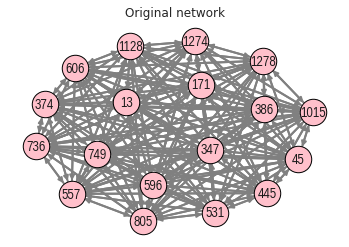

In [ ]:
def default_network_plot(G, ax=None, title=''):
  """
  Plot the network according to a default setting we decided upon.
  You can change the attributes accordingly
  """
  attrs = {
      "edge_color" : "gray",
      "edgecolors" : "black", # For Networkx 2.0
      "linewidths" : 1,       # For Networkx 2.0
      "font_family" : "Liberation Sans Narrow",
      "font_size" : 14,
      "node_color" : "pink",
      "node_size" : 700,
      "width" : 2,
  }
  pos = nx.nx_pydot.graphviz_layout(G)
  if ax is None:
    fig = plt.subplot()
    nx.draw(G, **attrs, pos=pos, labels = {i:i for i in G.nodes})
    plt.title(title, fontsize=12)
    plt.show()
  else:
    nx.draw(G, **attrs, pos=pos, labels = {i:i for i in G.nodes}, ax=ax)
    ax.set_title(title, fontsize=12)
  return

default_network_plot(G, title='Original network')

## Determine the threshold for pruning

In [ ]:
def slice_network_edges_by(G, by, copy=False, lower_limit=None, upper_limit=None):
  """
  Remove the edges that have {by} less than the specified lower_limit or more than the specified upper_limit
  Note that the limits are inclusive.
  """
  F = G.copy() if copy else G
  if not lower_limit is None: 
    F.remove_edges_from((u,v) for u, v, att in list(F.edges(data=by)) if att <= lower_limit)
  elif not upper_limit is None:
    F.remove_edges_from((u,v) for u, v, att in list(F.edges(data=by)) if att >= upper_limit)
  return F


def slice_by_threshold(G, thresholds):
  for thresh in thresholds:
    F = slice_network_edges_by(G, by='weight', copy=True, lower_limit=thresh)
    default_network_plot(F, title=f'weights: >{thresh}')
  return

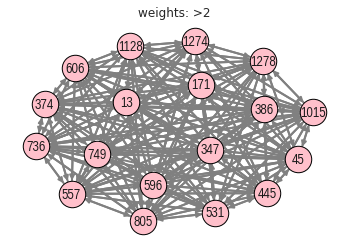

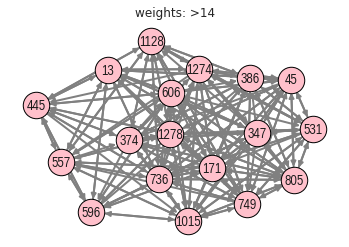

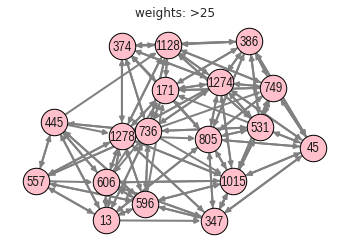

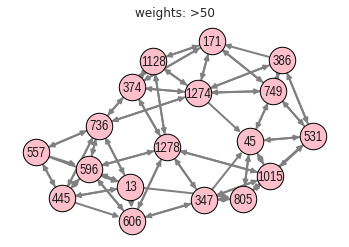

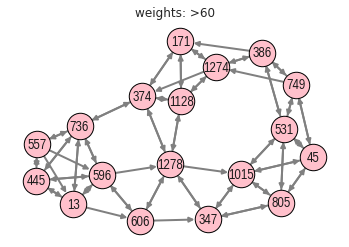

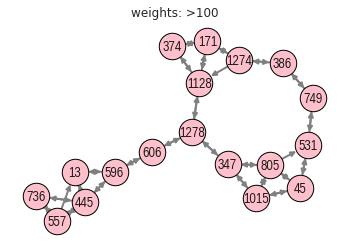

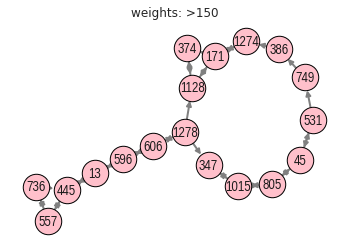

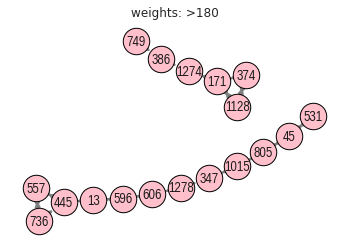

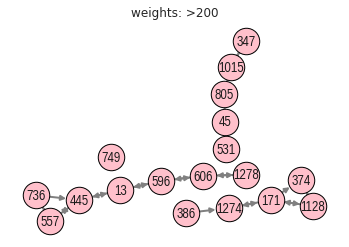

In [ ]:
# look at how the network look like after each slice
slice_by_threshold(G, [2, 14, 25, 50, 60, 100,150,180,200])

### Take away from analyzing the different graphs with different thresholds
- **The threshold for the weights are specific to the kind of business question the user is looking to answer.**

**Interpretating a graph with its specific threshold**
- Suppose we pruned a network G that gave us G' with a threshold of edge weights > 14. 
  - This means that there are **at least 14 students** who after taking exercise A, took exercise B

- Suppose we pruned a network G that gave us G* with a threshold of edge weights > 150. 
  - This means that there are **at least 150 students** who after taking exercise A, took exercise B 

**Comparing between exercises** 
- Compare **at least 14 students** and **at least 150 students**.
  Clearly, we can interpret that the relationship between the exercises in G* are a lot "stronger" than the relationship between exercises in G', since there are a lot more students who actually this learning path

**Example use cases**:

1. **Look for clusters of learning paths**
  - If we want to look for clusters of learning path, we **can** prune our weights > 180 as shown in the plot above
    - Reason: 
      - We managed to disconnect the graph and get 2 separate learning paths. 
      - The exercises in each learning path is more closely related to each other as compared to the learning path when we only prune our weights > 50. (refer back to "Comparing between exercises" above.)
      - We can thus potentially think of these 2 separate learning paths as the top 2 most popular learning paths that a student can take. This is useful if an instructor wants recommend popular learning paths.

2. **Check if a student has cleared the pre-requisite required to take an exercise**
  - If we want to check if a student can move on to a more advanced course, we **can no longer** prune our weights > 180.
    - Reason:
      - Suppose a student has taken exercise 1278 and want to know if he can take exercise 347. 
        - If we were to use the pruned graph with weights > 180, we would have said that the student cannot take it because there is no path between exercsie 1278 and 347. 
        - Giving this feedback to the student will be an error on the instructors part, because he had negligently pruned his network too much. 
        - Reason: 
          - if we had pruned this network  **less than 180** instead, there is actually a path from exercsie 1278 to 347
          - Look at the graph with weight > 150 for evidence that there is indeed a path


### Choose weights > 14 to demonstrate the ability of network analysis

- Although our network gets more interpretable when we prune more and more of our edges (You can see from the graphs above), it becomes less and less necessary to do network analysis.
  - For example, if we were to look at the graph with weights > 100, we can just eyeball the graph.
    - If we want to know if a student can take exercise 1278 to exercise 13, we can just stare at it without performing any network analysis.


- Network analysis shines when we are unable to eyeball the graph due to either too many nodes or too many edges.
  - As an example, look at the graph with weights > 4.
    - With so many edges, you will either take a lot of time to see if a student can take exercise 1278 to exercise 13, and you may make a lot of careless mistakes.
  - With this in mind, we chose the weights > 14 to demonstrate the ability of network analysis for the rest of the section below. 

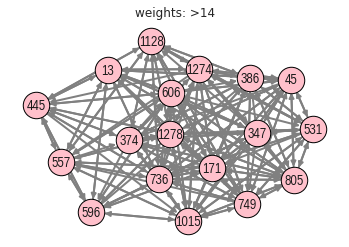

In [ ]:
F = slice_network_edges_by(G, by='weight', copy=True, lower_limit=14)
default_network_plot(F, title=f'weights: >{14}')

# Centrality Measures

**Centrality measures are commonly used to identify the important nodes across different business domains**
- The higher the value of these centrality measures mentioned below, the more important the node is.
  - Note that each centrality measure have different criterias to select important nodes.
  - To understand "how important" is according to the definition of each centrality measure.

You can refer to the links below to get some basic understanding about the centrality measures.
- https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python
- https://neo4j.com/docs/graph-algorithms/current/labs-algorithms/centrality/
- http://pi.math.cornell.edu/~mec/Winter2009/RalucaRemus/Lecture4/lecture4.html

In [ ]:
def get_centrality_measures(G):
  degree = nx.degree_centrality(G)
  closeness = nx.closeness_centrality(G)
  harmonic = nx.harmonic_centrality(G)
  eigenvalue = nx.harmonic_centrality(G)
  betweenness = nx.betweenness_centrality(G)
  page_rank = nx.pagerank(G)
  hits = nx.hits(G, max_iter=200) # https://stackoverflow.com/questions/63026282/error-power-iteration-failed-to-converge-within-100-iterations-when-i-tried-t
  names = ["Degree", "Betweenness", "Closeness", "Harmonic Closeness", "Eigenvector", "PageRank", "Authorities", "Hubs" ]
  all_measures = [degree, betweenness, closeness, harmonic, eigenvalue, page_rank, hits[1], hits[0]]
  return all_measures, names

def get_centralities_df(all_measures, names):
  df = pd.concat([pd.Series(measure) for measure in all_measures], axis=1)
  df.columns = names
  df["Harmonic Closeness"] /= df.shape[0] # normalize 
  return df

all_measures, names = get_centrality_measures(F)
df = get_centralities_df(all_measures, names)
df.describe().applymap(lambda x: round(x,3)).style.background_gradient('Blues', axis=1)

,Degree,Betweenness,Closeness,Harmonic Closeness,Eigenvector,PageRank,Authorities,Hubs
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,1.477000,0.016000,0.799000,0.821000,14.778000,0.056000,0.056000,0.056000
std,0.229000,0.009000,0.077000,0.055000,0.988000,0.010000,0.039000,0.040000
min,1.059000,0.007000,0.680000,0.722000,13.000000,0.041000,0.021000,0.022000
25%,1.309000,0.010000,0.739000,0.778000,14.000000,0.051000,0.026000,0.025000
50%,1.500000,0.012000,0.791000,0.819000,14.750000,0.054000,0.043000,0.044000
75%,1.618000,0.021000,0.810000,0.833000,15.000000,0.056000,0.071000,0.065000
max,1.941000,0.040000,0.944000,0.917000,16.500000,0.082000,0.177000,0.178000


- The mean, median, etc etc are used to get a sense of the distribution of the centrality measures across the network
  - For example, since the max and min of betweenness centrality is very close, perhaps you *can hypothesis* there is not much difference between the importance of the nodes in terms of betweenness centrality.
    - The disadvantage is, of course, the fact that  you need to really understand what each centrality is measuring.

## Identifying important nodes

1. **Get top "k" and bottom "k" exercises**
- By identifying the important nodes, we can obtain a list of important exercises for instructors to look at.
  - For the important exercises:
    - They can plan to improve on these exercises since they are important by pouring more resources into them or improving the learning materials used.
  - For the unimportant exercises:
    - Can look into replacing these exercises to avoid the waste of resources.

2. **Consistenly importatant and unimportant nodes**
- If we were to only get the top "k" and bottom "k" exercises to point us in the right direction to investigate our exercises, it may be the case that we have too many exercises to investigate. **Instructors do not have time for that!**
- * Thus, alternatively, we can look at exercises who consistently appear as important nodes, or consistency as unimportant nodes across the different centrality measures, so as to narrow down our scope for investigation.* 

In [ ]:
def get_top_bottom_k(df,by='Degree',k=10):
  df.sort_values(by, inplace=True, ascending=False)
  top_k = df.head(k)
  bottom_k = df.tail(k)
  print(f'Top_{k} "{by}" nodes:')
  for index, row in top_k.iterrows():
    print(f"Node: {index}, Val: {round(row[by],3)}, Description: {ucid_name_map[index]}")

  print(f'\nBottom_{k} "{by}" nodes:')
  for index, row in bottom_k.iterrows():
    print(f"Node: {index}, Val: {round(row[by],5)}, Description: {ucid_name_map[index]}")

  return top_k, bottom_k
important_nodes = []
unimportant_nodes = []
for measure in df.columns:
  print(f"\nImportant nodes using: {measure}")
  top_k, bottom_k = get_top_bottom_k(df, by=measure)
  important_nodes.extend(top_k.index)
  unimportant_nodes.extend(bottom_k.index)


Important nodes using: Degree
Top_10 "Degree" nodes:
Node: 736, Val: 1.941, Description: [Basics] Four arithmetic operations of fractions: parentheses are calculated first, first multiplied and divided, and then added 
Node: 1278, Val: 1.824, Description: [General] Mixed calculation of multiplication and division of fractions: Do not finish the calculation in parentheses 
Node: 171, Val: 1.706, Description: [Basic] Four arithmetic exercises on fractions and decimals 
Node: 1274, Val: 1.647, Description: [Basic] Four arithmetic word problems of fractions and decimals 
Node: 1015, Val: 1.647, Description: [Basics] Dividing two numbers is equal to dividing by the product of two numbers 
Node: 374, Val: 1.529, Description: 【Advanced】Comprehensive exercises on the four arithmetic operations of fractions and decimals 
Node: 606, Val: 1.529, Description: [Basic] Multiplication and division mixed calculation of fractions: mixed multiplication and division 
Node: 805, Val: 1.529, Description: 

In [ ]:
# Get consistently important and unimportant nodes
k = 5 # change this according to how many important nodes a user want to identify for further action 
from collections import Counter
important = Counter(important_nodes)
important_most_common = important.most_common(k)
print(f'Important nodes: {important_most_common}')

unimportant = Counter(unimportant_nodes)
unimportant_most_common = unimportant.most_common(k)
print(f'Unimportant nodes: {unimportant_most_common}')

Important nodes: [(736, 8), (171, 8), (374, 8), (1278, 7), (1274, 7)]
Unimportant nodes: [(347, 8), (531, 8), (45, 7), (805, 7), (445, 6)]


In [ ]:
# Look at all these important and unimportant nodes
for imp,_ in important_most_common:
  print(f'Important Node:{imp}: {ucid_name_map[imp]}')

for unimp,_ in unimportant_most_common:
  print(f'Unimportant Node: {unimp}: {ucid_name_map[unimp]}')

Important Node:736: [Basics] Four arithmetic operations of fractions: parentheses are calculated first, first multiplied and divided, and then added 
Important Node:171: [Basic] Four arithmetic exercises on fractions and decimals 
Important Node:374: 【Advanced】Comprehensive exercises on the four arithmetic operations of fractions and decimals 
Important Node:1278: [General] Mixed calculation of multiplication and division of fractions: Do not finish the calculation in parentheses 
Important Node:1274: [Basic] Four arithmetic word problems of fractions and decimals 
Unimportant Node: 347: [Basic] Subtracting two numbers in a row is equal to the sum of subtracting two numbers 
Unimportant Node: 531: [Basic] Two-step problem with decimals 
Unimportant Node: 45: 【Basic】Four arithmetic arithmetic of decimals 
Unimportant Node: 805: [Basics] Four arithmetic operations of decimals: distribution law 
Unimportant Node: 445: [Basics] Four arithmetic of fractions: associative law of addition 


- Now instead of looking at all the top k and bottom k, the instructor only need to look at 2*k exercises
  - However, if the instructor have time to spare, then definitely exploring all the top k and bottom k exercises will give more imformation about the exercises. 

### Visualizing important exercises using graphs
- Instead of the very verbose print statements above, we can also make the decision to convey which exercises are the important onces using graphs.
  - The bigger the node, the more important is the exercise according to the specific centrality measure. 

In [ ]:
custom_attr = {
    "linewidths" : 1,       # For Networkx 2.0
    "font_family" : "Liberation Sans Narrow",
    "font_size" : 14,
    "width" : 2,
}

my_node_size = [700 for node in F.nodes()]
my_node_color = ['pink' for node in F.nodes()]
my_edge_color = ['gray' for u, v ,data in G.edges(data=True)]
## uncomment this if you want to color your edge using the edge weights
# my_edge_color = [data['weight'] for u, v , data in F.edges(data=True)]
my_edge_cmap = plt.cm.Blues
my_layout_pos = nx.nx_pydot.graphviz_layout(F)
title = ""
def custom_network_plot(G, attr=custom_attr, pos=my_layout_pos, node_size = my_node_size, node_color=my_node_color, edge_color=my_edge_color, edge_cmap=my_edge_cmap, ax=None, title = title):
  if ax is None:
    fig, ax = plt.subplots(figsize=(16,10))
    nx.draw(G, **custom_attr, pos=pos, labels = {i:i for i in G.nodes}, node_size=node_size, node_color=node_color, edge_cmap = edge_cmap, edge_color=edge_color)
    plt.title(title, fontsize=30)
    plt.show()
  else:
    nx.draw(G, **custom_attr, pos=pos, labels = {i:i for i in G.nodes}, node_size=node_size, node_color=node_color, edge_cmap = edge_cmap, edge_color=edge_color, ax=ax)
    ax.set_title(title, fontsize=30)
    # plt.show()
  return

### Degree

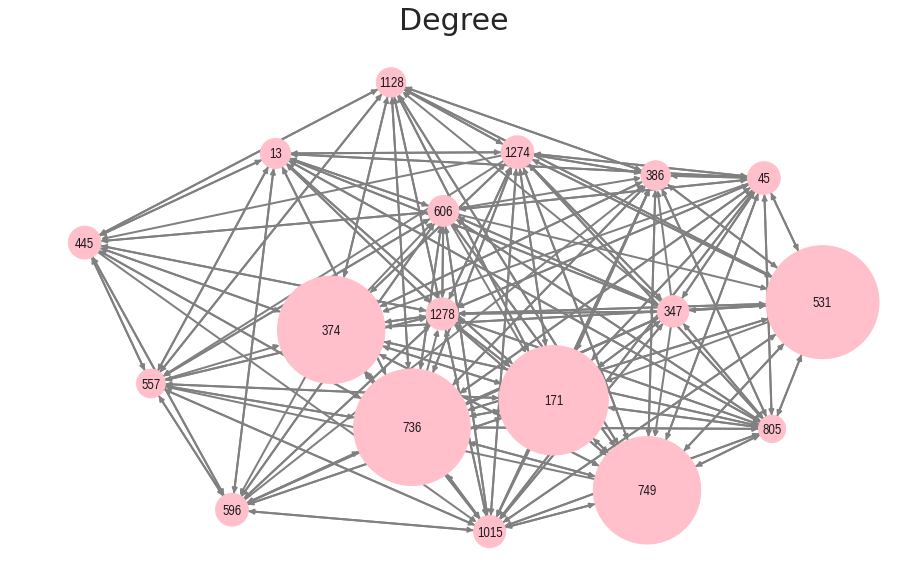

In [ ]:
## Degree
attr_map = {node:measure for node, measure in zip(df.index,df.Degree*700)}
top5 = list(map(lambda x: x[0],sorted(attr_map.items(),key=lambda x:x[1])[-5:]))

# adjust this measure_inflation to make the important nodes stand out even more
measure_inflation = 10
attr_map = {node:(measure * measure_inflation) if (node in top5) else measure for node, measure in attr_map.copy().items()}

# Change the default plot settings
my_node_size = list(attr_map.values())
my_layout_pos = nx.nx_pydot.graphviz_layout(F)
title = "Degree"
custom_network_plot(F, attr=custom_attr, pos=my_layout_pos, node_size = my_node_size, node_color=my_node_color, edge_color=my_edge_color, edge_cmap=my_edge_cmap, title = title)

### Betweenness

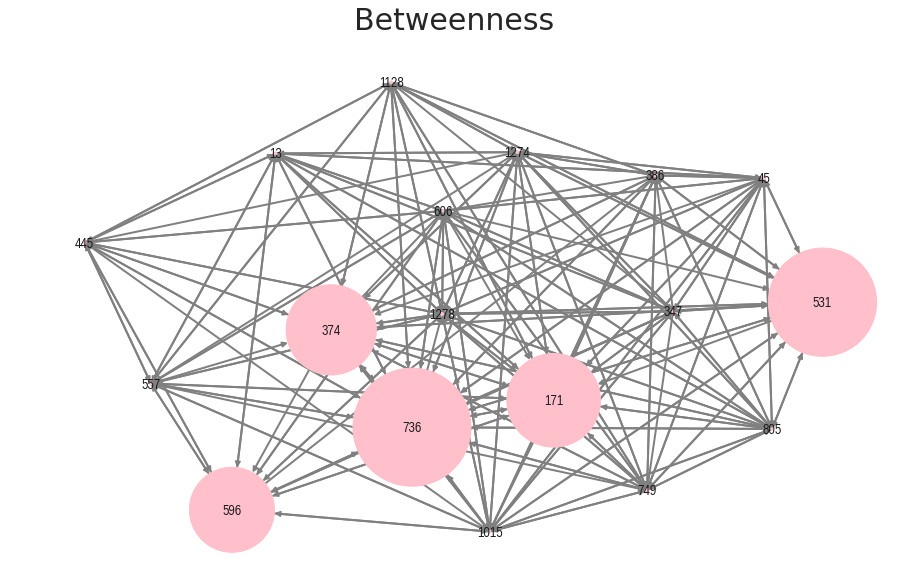

In [ ]:
## Betweenness
attr_map = {node:measure for node, measure in zip(df.index,df.Betweenness*700)}
top5 = list(map(lambda x: x[0],sorted(attr_map.items(),key=lambda x:x[1])[-5:]))

# adjust this measure_inflation to make the important nodes stand out even more
measure_inflation = 500
attr_map = {node:(measure * measure_inflation) if (node in top5) else measure for node, measure in attr_map.copy().items()}  

# Change the default plot settings
my_node_size = list(attr_map.values())
title = "Betweenness"
custom_network_plot(F, attr=custom_attr, pos=my_layout_pos, node_size = my_node_size, node_color=my_node_color, edge_color=my_edge_color, edge_cmap=my_edge_cmap, title = title)

### Closeness

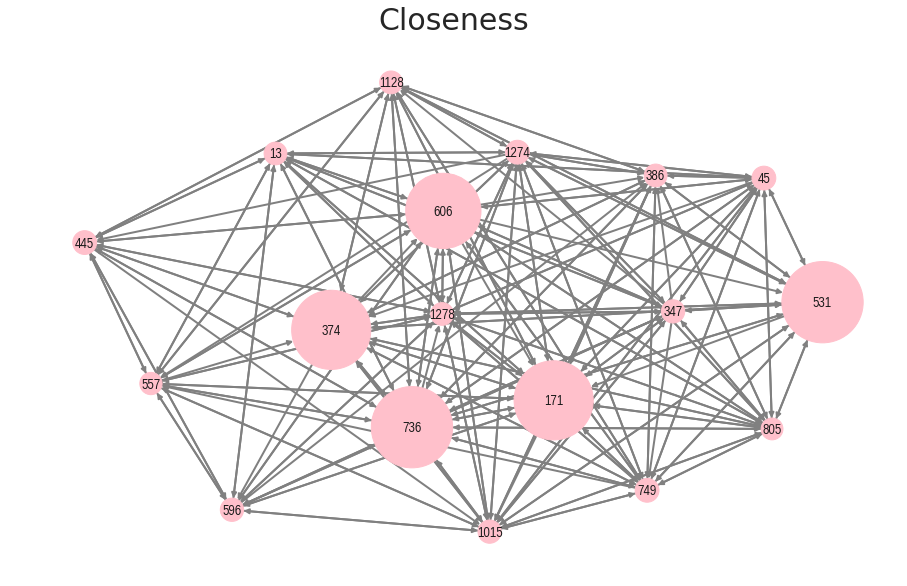

In [ ]:
## Closeness
attr_map = {node:measure for node, measure in zip(df.index,df.Closeness*700)}
top5 = list(map(lambda x: x[0],sorted(attr_map.items(),key=lambda x:x[1])[-5:]))

# adjust this measure_inflation to make the important nodes stand out even more
measure_inflation = 10
attr_map = {node:(measure * measure_inflation) if (node in top5) else measure for node, measure in attr_map.copy().items()}  

# Change the default plot settings
my_node_size = list(attr_map.values())
title = "Closeness"
custom_network_plot(F, attr=custom_attr, pos=my_layout_pos, node_size = my_node_size, node_color=my_node_color, edge_color=my_edge_color, edge_cmap=my_edge_cmap, title = title)

### Harmonic Closeness

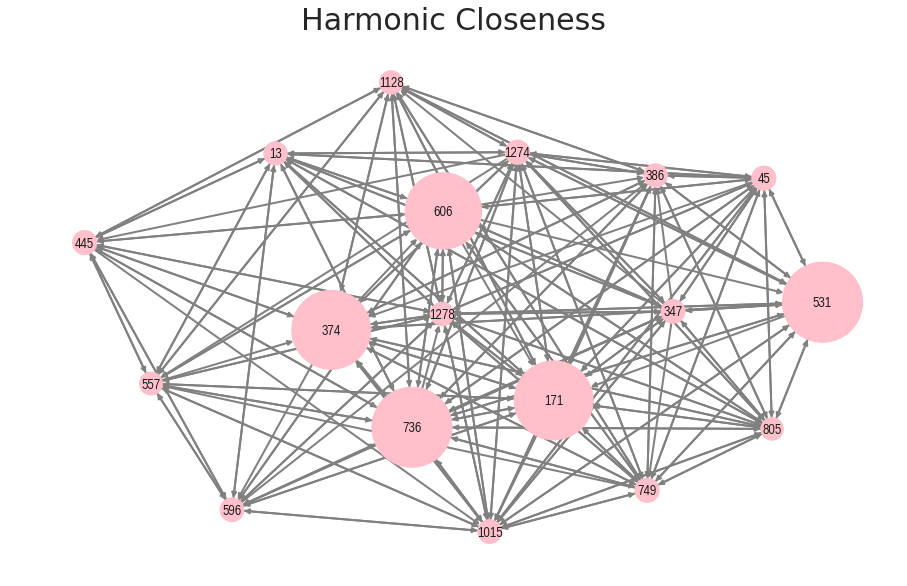

In [ ]:
## Harmonic Closeness
attr_map = {node:measure for node, measure in zip(df.index,df['Harmonic Closeness']*700)}
top5 = list(map(lambda x: x[0],sorted(attr_map.items(),key=lambda x:x[1])[-5:]))

# adjust this measure_inflation to make the important nodes stand out even more
measure_inflation = 10
attr_map = {node:(measure * measure_inflation) if (node in top5) else measure for node, measure in attr_map.copy().items()}  

# Change the default plot settings
my_node_size = list(attr_map.values())
title = "Harmonic Closeness"
custom_network_plot(F, attr=custom_attr, pos=my_layout_pos, node_size = my_node_size, node_color=my_node_color, edge_color=my_edge_color, edge_cmap=my_edge_cmap, title = title)

### Eigenvector

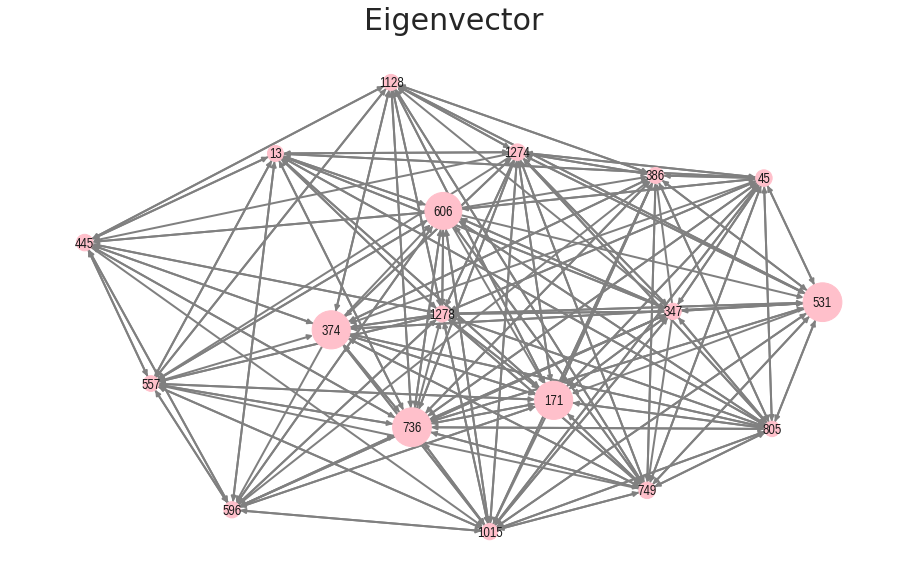

In [ ]:
## Eigenvector
attr_map = {node:measure for node, measure in zip(df.index,((df.Eigenvector*300)/max(df.Eigenvector)))}
top5 = list(map(lambda x: x[0],sorted(attr_map.items(),key=lambda x:x[1])[-5:]))

# adjust this measure_inflation to make the important nodes stand out even more
measure_inflation = 5
attr_map = {node:(measure*measure_inflation) if (node in top5) else measure for node, measure in attr_map.copy().items()} 

# Change the default plot settings
my_node_size = list(attr_map.values())
title = "Eigenvector"
custom_network_plot(F, attr=custom_attr, pos=my_layout_pos, node_size = my_node_size, node_color=my_node_color, edge_color=my_edge_color, edge_cmap=my_edge_cmap, title = title)

### PageRank

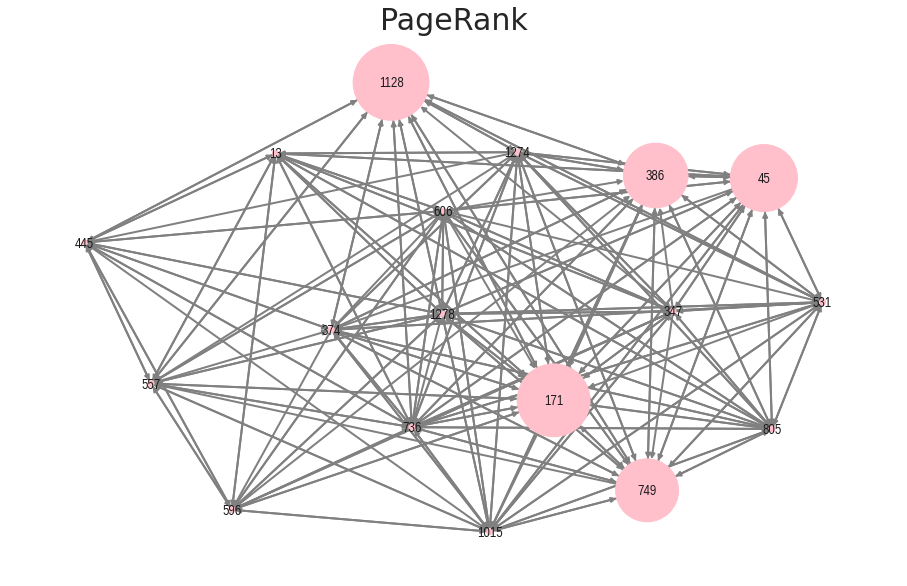

In [ ]:
## PageRank
attr_map = {node:measure for node, measure in zip(df.index,df.PageRank*700)}
top5 = list(map(lambda x: x[0],sorted(attr_map.items(),key=lambda x:x[1])[-5:]))

# adjust this measure_inflation to make the important nodes stand out even more
measure_inflation = 100
attr_map = {node:(measure * measure_inflation) if (node in top5) else measure for node, measure in attr_map.copy().items()}

# Change the default plot settings
my_node_size = list(attr_map.values())
title = "PageRank"
custom_network_plot(F, attr=custom_attr, pos=my_layout_pos, node_size = my_node_size, node_color=my_node_color, edge_color=my_edge_color, edge_cmap=my_edge_cmap, title = title)

### Authorities

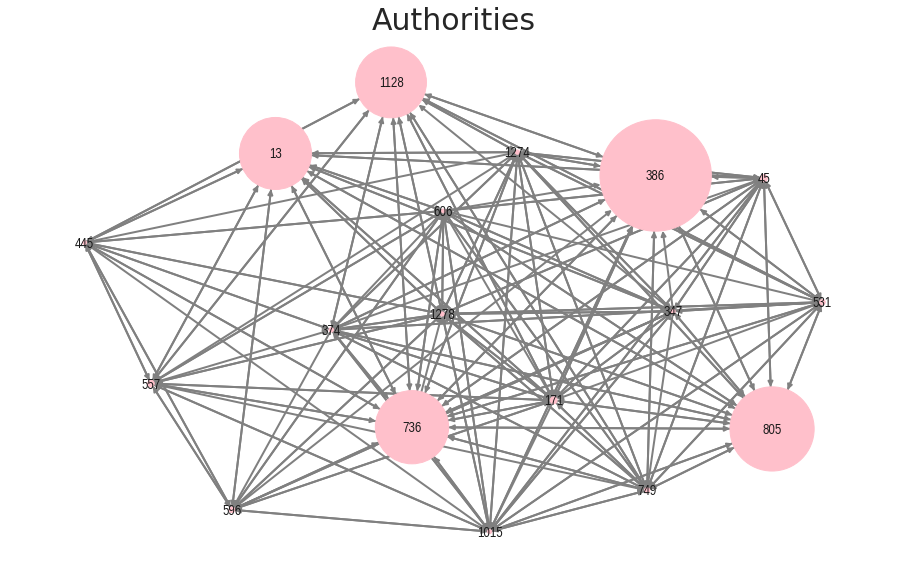

In [ ]:
## Authorities
attr_map = {node:measure for node, measure in zip(df.index,df.Authorities*700)}
top5 = list(map(lambda x: x[0],sorted(attr_map.items(),key=lambda x:x[1])[-5:]))

# adjust this measure_inflation to make the important nodes stand out even more
measure_inflation = 100
attr_map = {node:(measure * measure_inflation) if (node in top5) else measure for node, measure in attr_map.copy().items()} 

# Change the default plot settings
my_node_size = list(attr_map.values())
title = "Authorities"
custom_network_plot(F, attr=custom_attr, pos=my_layout_pos, node_size = my_node_size, node_color=my_node_color, edge_color=my_edge_color, edge_cmap=my_edge_cmap, title = title)

### Hubs

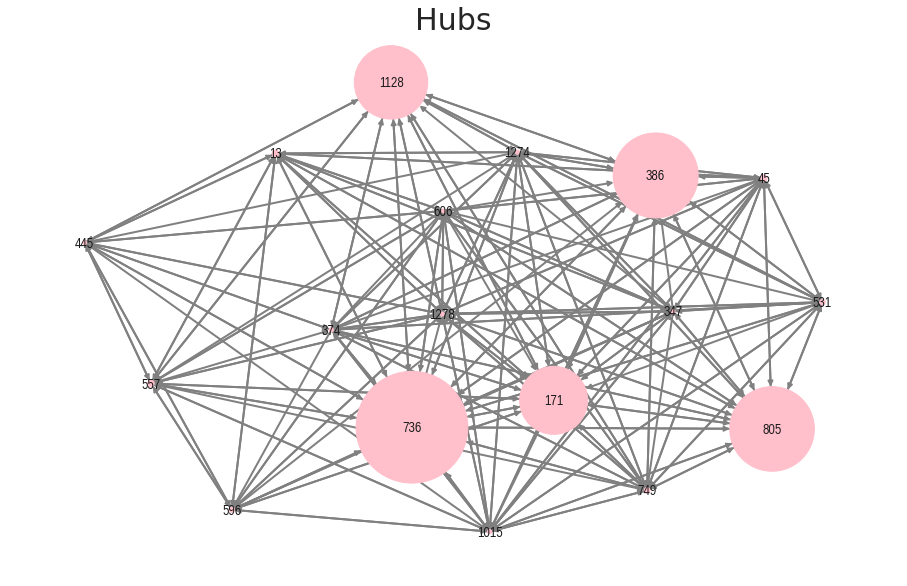

In [ ]:
## Hubs
attr_map = {node:measure for node, measure in zip(df.index,df.Hubs*700)}
top5 = list(map(lambda x: x[0],sorted(attr_map.items(),key=lambda x:x[1])[-5:]))

# adjust this measure_inflation to make the important nodes stand out even more
measure_inflation = 100
attr_map = {node:(measure * measure_inflation) if (node in top5) else measure for node, measure in attr_map.copy().items()} 

# Change the default plot settings
my_node_size = list(attr_map.values())
title = "Hubs"
custom_network_plot(F, attr=custom_attr, pos=my_layout_pos, node_size = my_node_size, node_color=my_node_color, edge_color=my_edge_color, edge_cmap=my_edge_cmap, title = title)

# Shortest paths

1. **Finding the shortest paths / Alternative paths from one exercise to another exercise**
  - In addition to finding the most popular learning path amongst all the shortest path
    - Reason:
      - Suppose there are 8 possible learning paths to recommend for a student, how will the student know which to choose? 
        - To answer this question, we are providing a guide for the students by showing the student the most popular learning paths.

2. **Identifying exercises to start and end.**
  - Given a starting exercise and ending exercises, we can find the shortest learning paths.
    - **However, which exercises should students start, and which exercises should student end?**
  - **Solution:** 
    - [Hubs and Authorities](http://pi.math.cornell.edu/~mec/Winter2009/RalucaRemus/Lecture4/lecture4.html) of the exercises (idea also used in search engines).
    - We have calculated these under the section "Centrality Measures" 
      - The idea is that:
      - 1. Exercises with higher number of students taking the exercise and then moving on to other exercises should be considered as starting exercises
          - Intuitively this means that a lot of students "start" at the exercises
      - 2. Exericises with higher number of students taking the exercise and then not moving on to other exercises should be considered as ending exercises.
          - Intuitively this means that a lot of students "end" at the exercises.
    - **Proposed used case**:
      - Identify potential starting exercises using exercises with the highest Hub score
      - Identify potential ending exercises using exercises with the highest Authority score

Using the idea of a search engine, we can perhaps go one step further in terms of recommending learning paths.
1. If a student wants to learn data science, filter for all the courses relevant to data science
2. Contruct a directed graph and calculate the Hub score and Authority score for each exercises.
3. Recommend exercises with the highest Hub score as the starting exercises.
4. Recommend exercises with the highest Authority score as the ending exercises

- Note that we did not try the "search engine way" because this is outside of the use case of our app, and this is just a hypothesis.

## Finding potential starting and ending exercises

In [ ]:
authorities_hubs = df[['Authorities','Hubs']].sort_values(by='Authorities')
authorities_hubs['Authorities_Rank'] = authorities_hubs['Authorities'].rank(ascending=False)
authorities_hubs['Hubs_Rank'] = authorities_hubs['Hubs'].rank(ascending=False)

k = 5 # adjust this number accordingly to the user's appetite
top_k_hubs = authorities_hubs[authorities_hubs['Hubs_Rank']<=k]
top_k_authorities = authorities_hubs[authorities_hubs['Authorities_Rank']<=k]
top_k_authorities

,Authorities,Hubs,Authorities_Rank,Hubs_Rank
1128,0.071653,0.077080,5.0,4.0
13,0.074100,0.062423,4.0,6.0
736,0.076674,0.178350,3.0,1.0
445,0.101264,0.102284,2.0,3.0
557,0.177341,0.103237,1.0,2.0


## Finding the shortest paths from potential starting and ending exercises.
- Important to note that for this shortest path, we are not using any edge weights or properties.
- You can interpret the shortest path here as the **smallest number of exercises that a student needs to take** if he wants to go from a starting exercises to a ending exercise.

In [ ]:
for hub in top_k_hubs.index:
  for aut in top_k_authorities.index:
    if hub != aut:
      print(f'src: {hub} => tgt: {aut}')
      try:
        print(f'Number of paths: {len(list(nx.all_shortest_paths(F,hub,aut)))}')
        for path in nx.all_shortest_paths(F, hub, aut):
          print(f"Available Paths: {path}")
          for ex in path:
            print(f'Node: {ex}: {ucid_name_map[ex]}')
          print()
      except nx.NetworkXNoPath:
        print('No Path Available')
      print('='*100) 

src: 171 => tgt: 1128
Number of paths: 1
Available Paths: [171, 1128]
Node: 171: [Basic] Four arithmetic exercises on fractions and decimals 
Node: 1128: 【General】Comprehensive exercises on the four arithmetic operations of fractions and decimals 

src: 171 => tgt: 13
Number of paths: 1
Available Paths: [171, 13]
Node: 171: [Basic] Four arithmetic exercises on fractions and decimals 
Node: 13: [Basic] Addition and subtraction mixed calculation of fractions: consecutive subtraction of two numbers 

src: 171 => tgt: 736
Number of paths: 1
Available Paths: [171, 736]
Node: 171: [Basic] Four arithmetic exercises on fractions and decimals 
Node: 736: [Basics] Four arithmetic operations of fractions: parentheses are calculated first, first multiplied and divided, and then added 

src: 171 => tgt: 445
Number of paths: 8
Available Paths: [171, 1128, 445]
Node: 171: [Basic] Four arithmetic exercises on fractions and decimals 
Node: 1128: 【General】Comprehensive exercises on the four arithmetic o

- We can see that from src = 171 to tgt = 445, there are actually 8 alternative paths!
- Using starting exercise as 171 and ending exercise as 445, we now find the most popular learning path

## Finding the most popular learning path
- After finding the shortest paths from one source to a target, there can be many alternative paths for a student to choose
- To help students to choose amongst these shortest path, we rank the shortest paths according to the popularity of the shortest learning paths

- Popularity in this section is defined as the number of times students(not necessary unique) take an exercise(target) after another exercise(source)
  - This popularity information is defined as an edge attribute and is alrady computed under the section "Create Directed Graph", and is called "weight"

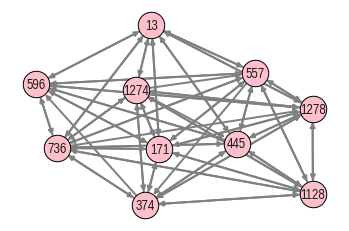

In [ ]:
start = 171
end = 445
nodes_involved_in_sp = pd.Series([i for lst in nx.all_shortest_paths(F, start, end) for i in lst]).unique()
nhood = nx.subgraph(F, nodes_involved_in_sp).copy()
edges_to_remove = [(n1, n2) for n1, n2 in nhood.edges() if n1 not in nodes_involved_in_sp and n2 not in nodes_involved_in_sp]
nhood.remove_edges_from(edges_to_remove)
default_network_plot(nhood)

- For finding the most popular learning path, we will make use use of the weight of our edges.
  - Since weight represents the number of students that take an exercise A and move on to exercise B, we want to recommend learning paths with the **highest** weights.
  - This is the **opposite of the shortest path algorithm** found in networkx, where we want to find the path with the **lowest** weights
  
- We thus define a new weight of our graph:
$$ new\_weight = -weight$$
  - The larger the original weight, the smaller the new_weight and vice-versa.
  - Example:
    - Original weight1 = 10, weight2=20
      - weight2 > weight1
    - new_weight1 = -10, new_weight2 = -20 
      - new_weight2 < new_weight1
  - we can thus now make use of the shortest path algorithm in networkx

In [ ]:
inverse_weight_dict = {(u,v):-w for u,v,w in nhood.edges(data='weight')}
nx.set_edge_attributes(nhood, inverse_weight_dict, "inverse_weight")

# create dictionary to color ALL EDGES  INVOLVED in the shortest path with the highest color

#### Create shortest path cost dictionary to color the graph! (A bit complicated, but if it is too hard, just rely on the print statements at the end of this section)
spc_dic = {}
for path in nx.all_shortest_paths(nhood, start, end):
  edges = [(path[index],path[index+1]) for index in range(len(path[:-1]))]
  total_path_cost = sum([nhood[u][v]['inverse_weight'] for u,v in edges])
  true_total_path_cost = sum([nhood[u][v]['weight'] for u,v in edges])
  for u,v in edges:
    spc_dic[(u,v)] = true_total_path_cost

# create a max limit because there may be edges involved in the network that are not involved in any shortest path. We want to limit the visual impact of this edges
max_total_path_cost = max(spc_dic.values())

In [ ]:
# create the colors to make it visually appealling on the popular learning paths
color_att ={(u,v):spc_dic[(u,v)] if (u,v) in spc_dic else spc_dic[(v,u)] if (v,u) in spc_dic else min(max_total_path_cost, data['weight']) for u, v, data in nhood.edges(data=True)}
nx.set_edge_attributes(nhood, color_att, 'color')
colors = list(nx.get_edge_attributes(nhood,'color').values())

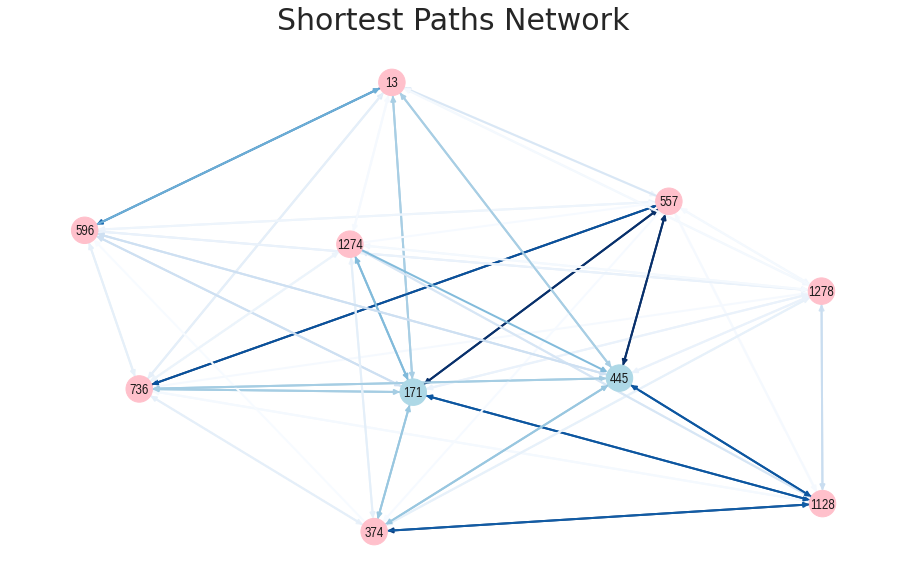

In [ ]:
custom_attr = {
    "linewidths" : 1,       # For Networkx 2.0
    "font_family" : "Liberation Sans Narrow",
    "font_size" : 14,
    "width" : 2,
}

my_node_size = [700 for node in nhood.nodes()]
my_node_color = ['lightblue' if node == start or node==end else 'pink' for node in nhood.nodes()]

# # create the colors to make it visually appealling on the popular learning paths
## what this is doing is to color all the edges in a path according to the path cost. This is only for visualization
## this will be not useful if the edge lies in the many alternative paths, since the color of this edge will be determined by the path cost associated with the edge, last seen in the for loop. 
my_edge_color = [spc_dic[(u,v)] if (u,v) in spc_dic else spc_dic[(v,u)] if (v,u) in spc_dic else min(max_total_path_cost, data['weight']) for u, v, data in nhood.edges(data=True)] # Hack on coloring directed edges since edges are overlapping
my_edge_cmap = plt.cm.Blues
my_layout_pos = nx.nx_pydot.graphviz_layout(nhood)
title = "Shortest Paths Network"

def custom_network_plot(G, attr=custom_attr, pos=my_layout_pos, node_size = my_node_size, node_color=my_node_color, edge_color=my_edge_color, edge_cmap=my_edge_cmap, ax=None, title = title):
  if ax is None:
    fig, ax = plt.subplots(figsize=(16,10))
    nx.draw(G, **custom_attr, pos=pos, labels = {i:i for i in G.nodes}, node_size=node_size, node_color=node_color, edge_cmap = edge_cmap, edge_color=edge_color)
    plt.title(title, fontsize=30)
    plt.show()
  else:
    nx.draw(G, **custom_attr, pos=pos, labels = {i:i for i in G.nodes}, node_size=node_size, node_color=node_color, edge_cmap = edge_cmap, edge_color=edge_color, ax=ax)
    ax.set_title(title, fontsize=30)
    # plt.show()
  return

custom_network_plot(nhood, attr=custom_attr, pos=my_layout_pos, node_size = my_node_size, node_color=my_node_color, edge_color=my_edge_color, edge_cmap=my_edge_cmap, ax=None, title = title)

- From the network and the code below, we can see that the most popular learning path is 171 to 557 to 445!
- The code below adds an additional statement "total_path_cost" so that we can see which learning path is the most popular

In [ ]:
for path in nx.all_shortest_paths(nhood, start, end):
  print(f"Available Paths: {path}")
  edges = [(path[index],path[index+1]) for index in range(len(path[:-1]))]
  total_path_cost = sum([nhood[u][v]['weight'] for u,v in edges])
  print(f'total_path_cost: {total_path_cost}')
  for ex in path:
    print(f'Node: {ex}: {ucid_name_map[ex]}')
  print()

Available Paths: [171, 1128, 445]
total_path_cost: 574
Node: 171: [Basic] Four arithmetic exercises on fractions and decimals 
Node: 1128: 【General】Comprehensive exercises on the four arithmetic operations of fractions and decimals 
Node: 445: [Basics] Four arithmetic of fractions: associative law of addition 

Available Paths: [171, 1274, 445]
total_path_cost: 306
Node: 171: [Basic] Four arithmetic exercises on fractions and decimals 
Node: 1274: [Basic] Four arithmetic word problems of fractions and decimals 
Node: 445: [Basics] Four arithmetic of fractions: associative law of addition 

Available Paths: [171, 736, 445]
total_path_cost: 248
Node: 171: [Basic] Four arithmetic exercises on fractions and decimals 
Node: 736: [Basics] Four arithmetic operations of fractions: parentheses are calculated first, first multiplied and divided, and then added 
Node: 445: [Basics] Four arithmetic of fractions: associative law of addition 

Available Paths: [171, 374, 445]
total_path_cost: 270
No

# Alternative ways to recommend learning paths
- The code below is meant to guide the reader as to how the formula is being calculated, and not meant to be ran.

## (a) Individual_number_of_students
- Instead of using the number of **students(not unique)** who took an exercise(target) after another exercise(source), we consider the popularity of the exercise as the number of **unique students** who took an exercise(target) after another exercise(source).
<hr>

- let $S$ denote all the starting exercises.
- let $E$ denote all the ending exercises.
- let $K$ denote the individual students.


$ \forall i \in S, \forall j \in E, i\neq j,$
$$edge(i,j) = \sum_{k=1}^{|K|}(student(k)\_took\_exercise(j)\_after(i) == 1)$$

## (b) Aggregated student performance from the mean
- Sometimes the exercises are mandatory, and therefore using the popularity of the learning paths may not be meaningful ; since we will just be recommending the mandatory exercises.
- To give instructors/students more options to choose learning path, we used student performance as another alternative when recommending learning paths.

This is computed using the following formula:

- let $S$ denote all the starting exercises.
- let $E$ denote all the ending exercises.
- let $W$ denote the arbitrary exercises.
- let $K$ denote the individual students.
- let $P_e$ denote all the problem sets in an exercise e.

Let $\ k \in K, e \in W$,

$$ performance(k)_e = \mathbb{E}\left[\forall p \in P_e, is\_correct(p)\right]
 \tag{1}$$



$\forall e \in W$, let in_degree(e) be the exercises that have been historically taken before exercise e, then:

$$ Avg_{j} = \mathbb{E}\left[\forall i \in degree(j), performance(k)_j \ after  \ exercise \ i\right] \tag{2} $$

Thus,
$ \forall i \in S, \forall j \in E,i\neq j,$
$$ edge(i,j) =  \mathbb{E}\left[\forall k \in K, performance(k)_i \right] - Avg_j \tag{3} $$

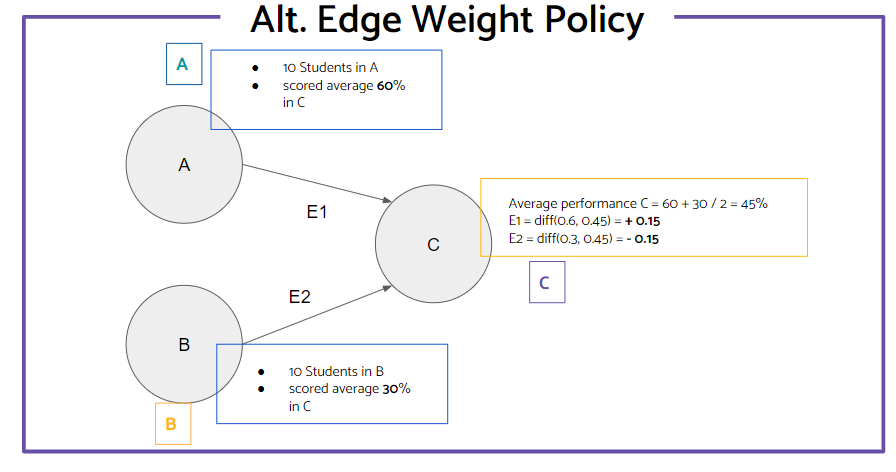

**Layman Explanation of the picture above:**

The edge weight between Node A and C is the: 

> Relative performance of students **from** node A **in** node C compared to the overall performance of all students **in** node C.

- The code below stores (a) individual_number_of_students, and (b) Aggregated student performance from the mean as edge attributes.

In [ ]:
## Function to calculate edge weight as illustrated in the picture above
def get_true_edge(G):
  """
  Using the auxillary edge weights, create the final weight as shown in the diagram above
  """
  # calculate the average performance. handles part A
  average_score_from_src_to_tgt_dic = {(u,v): (dic['sum_of_correct_problems']/dic['number_of_individual_students']) for u,v,dic in G.edges(data=True)}
  nx.set_edge_attributes(G, average_score_from_src_to_tgt_dic, 'average_score_from_src_to_tgt')
  
  # calculate the average performance of the target. handles part B
  def calc_average_performance_on_tgt(node):
    lst = list(map(lambda x: x[2],G.in_edges(node, data='average_score_from_src_to_tgt')))
    return np.mean(lst) if len(lst) > 0 else 0

  average_performance_on_tgt = {node:calc_average_performance_on_tgt(node) for node in G.nodes()}
  nx.set_node_attributes(G, average_performance_on_tgt, 'average_performance_tgt')

  # calculate the actual weight according to part C
  final_average_performance_dic = {(u,v): (w - G.nodes[v]['average_performance_tgt']) for u,v,w in G.edges(data='average_score_from_src_to_tgt')}
  nx.set_edge_attributes(G, final_average_performance_dic, 'final_average_performance')

  # set the popularity of the learning path based on 
  return G

In [ ]:
# create SUM student performance for each student on a particular exercise
student_sum_performance = flp.groupby(['uuid','ucid'], sort=False)['is_correct'].sum().reset_index().rename(columns={'is_correct':'sum_is_correct'})
# Remove duplications of students and exercise since we aggregated the result in the df above
flp_student_sum_performance = flp.drop_duplicates(subset=['uuid','ucid']).merge(student_sum_performance, left_on=['uuid','ucid'], right_on=['uuid','ucid'])

# create the dataframe to create our graph
user_to_content_student_performance = flp_student_sum_performance.groupby(['uuid'], sort=False)['ucid2'].apply(lambda x: x.tolist()).reset_index()
# store the sum of the individual score as an auxillary data
user_to_content_student_performance['individual_sum_score'] = flp_student_sum_performance.groupby(['uuid'], sort=False)['sum_is_correct'].apply(lambda x: x.tolist()).values


# # need to remove students who only took one exercise, since they do not contribute to edge weight
user_to_content_student_performance = user_to_content_student_performance[user_to_content_student_performance['ucid2'].apply(lambda x:len(x)>1)]
# "shift" then exercise taken by the student to the right to represent "source"
user_to_content_student_performance['from'] = user_to_content_student_performance['ucid2'].apply(lambda x: x[:-1])
# "shift" then exercise taken by the student to the left to represent "target"
user_to_content_student_performance['to'] = user_to_content_student_performance['ucid2'].apply(lambda x: x[1:])
# "shift" then sum scores taken by the student to the left to represent the sum scores on "target" after the "source"
user_to_content_student_performance['individual_sum_score_to'] = user_to_content_student_performance['individual_sum_score'].apply(lambda x: x[1:])
user_to_content_student_performance.head()

In [ ]:
def create_networkx_graph(user_to_content_student_performance):
  """
  Create the graph according to the given inputs

  """
  G = nx.DiGraph()
  for index, row in user_to_content_student_performance.iterrows():
      user = row['uuid']
      from_list = row['from']
      to_list = row['to']
      individual_sum_score_to = row['individual_sum_score_to']
      # always check that the number 
      for src, tgt, score in zip(from_list, to_list, individual_sum_score_to):
        if G.has_edge(src, tgt):
            G[src][tgt]['number_of_individual_students'] += 1
            G[src][tgt]['sum_of_correct_problems'] += score
        else:
            G.add_edge(src, tgt, sum_of_correct_problems=score, number_of_individual_students=1)
  return get_true_edge(G)
  
G = create_networkx_graph(user_to_content_student_performance)

##(c) Student performance from the mean
- Alternative to the student performance from the mean defined in (b), which takes the relative performance of students from node A (as a whole) compared to the to the overall performance of all students in node C,
  - Another alternative way is to consider each student performance individually(Instead of aggregating the performance for all the students).
  

- let $S$ denote all the starting exercises.
- let $E$ denote all the ending exercises.
- let $W$ denote the arbitrary exercises.
- let $K$ denote the individual students.
- let $P_e$ denote all the problem sets in an exercise e.

Let $\ k \in K, e \in W$,
$$ performance(k)_e = \mathbb{E}\left[\forall p \in P_e, is\_correct(p)\right]
 \tag{1}$$

$\forall j \in E,$
$$ Avg*_j = \mathbb{E}\left[ \forall k \in K, performance(k)_e\right] \tag{2}$$


$ \forall i \in S, \forall j \in E, i \neq j,$
$$ edge(i,j) = \sum_{k=1}^{|K|} \left((performance(k)_j \ after \ exercise \ i) - Avg*_j)\right) \tag{3}$$

**Why does this make sense mathematically?**

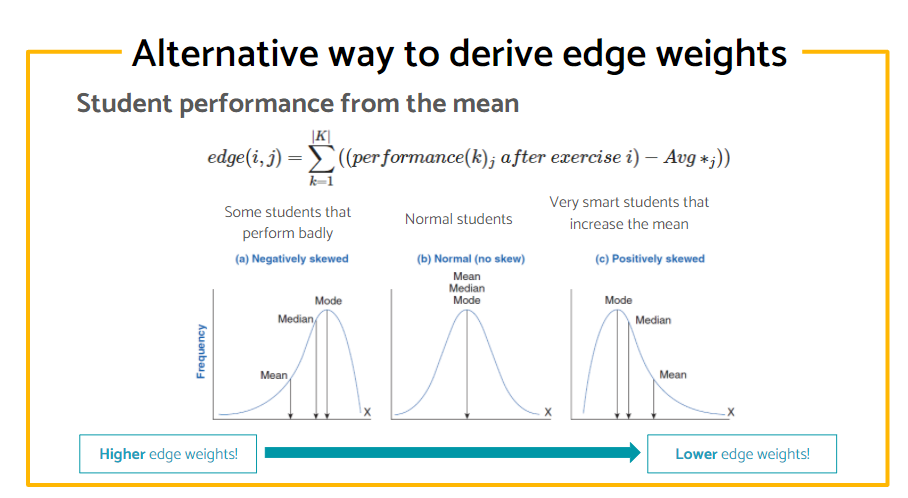

- The reason for definining the edge weight like the above to **find learning paths that contain exercises such that students can perform better than the average student on an execise**, where the average student is the average of all the student's performance on that particular exercise.

- There are generally three kinds of distributions
  - Negatively skewed
    - Exercises that historically, have more students that perform badly 
  - No skew
    - Exericses that historically, have a roughly even distribution of good and bad students
  - Positively skewed
    - Exercises that historically, have more students that perform well. 
- With reference to the image above, let us look at:
  1. Why exercises with negatively skewed student performance will have higher edge weights, and exercises with more positively skewed student performance will have lower edge weights

  2. Why we prefer exercises with negatively skewed student performance as compared to positively skewed student performance.

<hr>

 - **Positively skewed**: in the case of student performance, we can think of them as exercises that historically have more smart students that score very well.
    - Since we have students that perform well, they will increase the mean of the student performance on that exercise (**Avg*j** will increase).
    - Referring back to our equation above, if **Avg*j** increase, this means our **edge(i,j)** will decrease.
      - **This implies that if the learning path contains exercises with higher mean student performance, the edge weights will be less positive**
    - **So why is higher mean student performance bad**? 
        - if the mean increases, you can see that there are **less students who actually score higher than the mean**(as illustrated by the lower larger area under the curve to the right side of the mean)
        - This means that if i am a student taking this exercise, **there is a lower probability for me to perform better than the average student**.
    - **Takeaway**: 
        - For exercises with a positively skewed student performance, the edge weights will tend to be lower. 
        - This is what we **do not** want because this means that we have a lower chance to perform better than the average student if we take this exercise. 

<hr>

 - **Negatively skewed**: in the case of student performance, we can think of them as exercises with more students that historically perform badly.
    - Since we have students that perform badly, they will decrease the mean of the student performance on that exercise (**Avg*j** will decrease).
    - Referring back to our equation above, if **Avg*j** decreases, this means our **edge(i,j)** will increase.
      - **This implies that if the learning path contains exercises with lower mean student performance, the edge weights will be more positive**
  - **So why is lower mean student performance good**? 
      - if the mean decreases, you can see that there are **more students who actually score higher than the mean**(as illustrated by the larger area under the curve to the right side of the mean)
      - This means that if i am a student taking this exercise, **there is a higher probability for me to perform better than the average student**.
    - **Takeaway**: 
      - For exercises with a negatively skewed student performance, the edge weights will be high. 
      - This is what we **want** because this means that we have a higher chance to perform better than the average student if we take this exercise. 

**Conclusion**
- We prefer exercises with negatively skewed student performance because this means we have a higher chance to perform better than the average student
- These exercises will tend to have more positive edge weights
- When recommending learning paths, we aim to recommend one such that the exercises tend to be more negatively skewed as possible 

**Extensions**
- Instead of comparing against the average student, we can compare against the 25th percentile's, 50th percentile's or 75th percentile's, etc student performance. These can be useful if the student or instructor cares about the bell curve, and this also makes the way we recommend learning paths highly customizable for the instructor/student's preference.

In [ ]:
# create average student performance for each student on a particular exercise, is_correct2 is 1 if student got it correct, else 0.
student_mean_performance = log_problem_filtered2.groupby(['uuid','ucid'], sort=False)['is_correct2'].mean().reset_index().rename(columns={'is_correct2':'mean_is_correct2'})
# Remove duplications of students and exercise since we aggregated the result in the df above
log_problem_student_mean_performance = log_problem_filtered2.drop_duplicates(subset=['uuid','ucid']).merge(student_mean_performance, left_on=['uuid','ucid'], right_on=['uuid','ucid'])

# test logic
uuid_test='foN8F0t1b10IWVMaLqKQSAIPvyTgsAlv+b7OU0TdIvs='
ucid_test = 'XPxKzkvjDB7yK2AQPahFqPB7cnoHs5/dy4T498HoX5M='
assert (log_problem[(log_problem['uuid']== uuid_test) & (log_problem['ucid']==ucid_test)]['is_correct'].mean()) == (log_problem_student_mean_performance[(log_problem_student_mean_performance['uuid']== uuid_test) & (log_problem_student_mean_performance['ucid']==ucid_test)]['mean_is_correct2'].iloc[0])


In [ ]:
# create the dataframe to create our graph
user_to_content_student_performance = log_problem_student_mean_performance.groupby(['uuid'], sort=False)['ucid2'].apply(lambda x: x.tolist()).reset_index()
# Store the individual scores
user_to_content_student_performance['individual_mean_score'] = log_problem_student_mean_performance.groupby(['uuid'], sort=False)['mean_is_correct2'].apply(lambda x: x.tolist()).values
# sanity check to ensure that the code is correct
assert log_problem_student_mean_performance[log_problem_student_mean_performance['uuid']==user_to_content_student_performance.loc[0,'uuid']]['mean_is_correct2'].tolist() == user_to_content_student_performance.loc[0,'individual_mean_score']
assert user_to_content_student_performance['ucid2'].apply(lambda x: len(x)).equals(user_to_content_student_performance['individual_mean_score'].apply(lambda x: len(x)))
# need to remove students who only took one exercise, since they do not contribute to edge weight
user_to_content_student_performance = user_to_content_student_performance[user_to_content_student_performance['ucid2'].apply(lambda x:len(x)>1)]
# "shift" the exercises that students took by removing the last index. this will be considered as the list of from exercises
user_to_content_student_performance['from'] = user_to_content_student_performance['ucid2'].apply(lambda x: x[:-1])
# "shift" the exercises that students took by removing the first index, this will be considered as the list of target exercises
user_to_content_student_performance['to'] = user_to_content_student_performance['ucid2'].apply(lambda x: x[1:])
# obtain the average score that a student obtained from each source to target. This is obtained by doing the "shift" by removing the first index as well.
user_to_content_student_performance['individual_mean_score_to'] = user_to_content_student_performance['individual_mean_score'].apply(lambda x: x[1:])


# find the average of the mean performance of ALL students on a particular exercise. [yes, i am taking the average of the average], this is for use later
average_student_performance = log_problem_student_mean_performance.groupby(['ucid2'])['mean_is_correct2'].mean().to_dict()

# create the Graph to store the information
G = nx.DiGraph()
for index, row in user_to_content_student_performance.iterrows():
    user = row['uuid']
    from_list = row['from']
    to_list = row['to']
    individual_mean_score_to = row['individual_mean_score_to']
    # always check that the number 
    for src, tgt, score in zip(from_list, to_list, individual_mean_score_to):
        if G.has_edge(src, tgt):
            G[src][tgt]['number_of_individual_students'] += 1
            # update the weight of the edge
            G[src][tgt]['weighted_student_perf'] += score - average_student_performance[tgt]
        else:
            G.add_edge(src, tgt, weighted_student_perf =  score - average_student_performance[tgt], number_of_individual_students=1)

<hr>

# Comparing the network across different student personas

## How different are the structure of the network for each of the student personas

In [ ]:
# get back the cluster that the student belongs to
user_to_content = user_to_content.merge(labels, left_on = 'uuid', right_on='uuid')

In [ ]:
from na_recommendation.compare_student_personas import create_directed_graph, StoreNetworkMeasures, CompareCentralityMeasures

# Create an object to help create 
SNM = StoreNetworkMeasures()
CCM = CompareCentralityMeasures()
# create the original network to compare with the other student personas networks
OG = create_directed_graph(user_to_content)
network_measure_info = SNM.load_graph(OG,'original_graph').run()
centrality_info = CCM.load_graph(OG,'original_graph').compareTo(OG) # compare with itself

# run through the entire student persona dataframe
for persona in user_to_content['labels'].unique():
  persona_user_to_content = user_to_content[user_to_content['labels'] == persona]
  persona_G = create_directed_graph(persona_user_to_content)
  persona_df_name = f'persona{persona}_network'
  network_measure_info = SNM.load_graph(persona_G, persona_df_name).run()
  print(f'len(personaG):{len(persona_G)}')
  centrality_info = CCM.load_graph(persona_G, persona_df_name).compareTo(OG) # compare the persona network with the original network

Finished 'create_directed_graph' in 20.776 secs

Storing measures for original_graph
Density of network: 0.22516975440393863
Triadic Closure of network: 0.5400136258370033
Network is connected: True
Number of components in the network: 1
Number of nodes in the largest network: 1326
Network diameter of largest component: 3
Finished 'run' in 469.969 secs

Comparing original_graph to specified graph
Finished 'compareTo' in 322.41 secs
Finished 'create_directed_graph' in 9.535 secs

Storing measures for persona1_network
Density of network: 0.1394530293975355
Triadic Closure of network: 0.4325016915192182
Network is connected: True
Number of components in the network: 1
Number of nodes in the largest network: 1326
Network diameter of largest component: 4
Finished 'run' in 316.676 secs
len(personaG):1326

Comparing persona1_network to specified graph
Finished 'compareTo' in 257.732 secs
Finished 'create_directed_graph' in 1.994 secs

Storing measures for persona3_network
Density of network: 

### visualizing the network measures information (network level)

In [ ]:
network_measure_info.style.background_gradient('Blues', axis=1)

,original_graph,persona1_network,persona3_network,persona0_network,persona4_network,persona2_network
index,,,,,,
density,0.225000,0.139000,0.019000,0.014000,0.036000,0.171000
triadic_closure,0.540000,0.433000,0.221000,0.186000,0.249000,0.502000
num_components,1.000000,1.000000,9.000000,4.000000,1.000000,1.000000
max_component_len,1326.000000,1326.000000,1296.000000,1317.000000,1324.000000,1326.000000
max_component_diameter,3.000000,4.000000,8.000000,7.000000,10.000000,4.000000


### visualizing the centrality measures (node level)

In [ ]:
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
centrality_info.applymap(lambda x: x*100).style.background_gradient(cm, axis=1, high = 0.04)

,original_graph,persona1_network,persona3_network,persona0_network,persona4_network,persona2_network
index,,,,,,
degree,0.000000,38.000000,92.000000,94.000000,84.000000,24.000000
closeness,0.000000,6.000000,37.000000,43.000000,32.000000,5.000000
betweenness,0.000000,34.000000,167.000000,207.000000,127.000000,21.000000
eigenvector,0.000000,11.000000,54.000000,62.000000,39.000000,11.000000


## Example paths from each student personas

In [10]:
from na_recommendation import utils as myutils
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
# labels = pd.read_csv('labels.csv')
# log_problem = log_problem.merge(labels, left_on='uuid', right_on='uuid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
def read_path(paths):
  for path , cost in paths:
    print(f'path: {path}')
    for ex in path:
      print(f'\t=>{ucid_name_map[ex]}')
    print('=' * 100)

criterions = ['number_of_individual_students', 'final_average_performance', 'shortest_path']
level4_ids = info_content['level4_id'].unique()
for choice in criterions:
  print(f'choice: {choice} \n{"="*100}\n{"="*100}')
  for label in sorted(log_problem['labels'].unique()):
    print(f'{" "*25 + "*"*25} Label: {label} {"*"*25 + " "*25} \n{"-"*100}')
    log_problem_sub = log_problem[log_problem['labels']==label]
    res, g = myutils.recommend_learning_paths(log_problem_sub, info_content, level4_ids, num_paths=3, min_path_length=5, method = choice)
    read_path(res['paths'][:3]) 

choice: number_of_individual_students 
                         ************************* Label: 0 *************************                          
----------------------------------------------------------------------------------------------------
path: [1028, 1059, 981, 164, 1150]
	=>【Basic】Using the distribution law to evaluate 
	=>[Basic] Distributive law: single term multiplied by double term 
	=>【Basic】Using the square formula of sum to evaluate 
	=>【Basic】Using the square formula of difference to evaluate 
	=>【Basic】Using the square difference formula to evaluate 
path: [1028, 1059, 981, 1150, 164]
	=>【Basic】Using the distribution law to evaluate 
	=>[Basic] Distributive law: single term multiplied by double term 
	=>【Basic】Using the square formula of sum to evaluate 
	=>【Basic】Using the square difference formula to evaluate 
	=>【Basic】Using the square formula of difference to evaluate 
path: [1059, 1028, 981, 164, 1150]
	=>[Basic] Distributive law: single term multiplied by 

## Comparing the best and worst paths recommended
- Note that this functionality is not incorporated in the code, thus it is not recommend to run through the code verbatim.
- The worst path is obtained through commenting out the "G = convert_edge_weights_for_dijstra(G, method)" on line 327.
- line 266 "method = 'neg_' + orig_method if orig_method != "shortest_path" else orig_method" must be commented out as well

### Comparing final_average_performance

#### Best paths

In [24]:
def read_path(paths):
  for path, cost in paths:
    print(f'path: {path}, total_path_cost={cost}')
    for ex in path:
      print(f'\t=>{ucid_name_map[ex]}')
    print('=' * 100)

criterions = ['final_average_performance']
level4_ids = info_content['level4_id'].unique()
for choice in criterions:
  print(f'choice: {choice} \n{"="*100}\n{"="*100}')
  for label in sorted(log_problem['labels'].unique()):
    print(f'{" "*25 + "*"*25} Label: {label} {"*"*25 + " "*25} \n{"-"*100}')
    log_problem_sub = log_problem[log_problem['labels']==label]
    res, g = myutils.recommend_learning_paths(log_problem_sub, info_content, level4_ids, num_paths=3, min_path_length=10, method = choice)
    read_path(res['paths'][:3])
    break
  break

choice: final_average_performance 
                         ************************* Label: 0 *************************                          
----------------------------------------------------------------------------------------------------
path: [888, 481, 1090, 691, 297, 821, 1221, 853], total_path_cost=[5.614285714285714, 3.929278711484595, 6.727383633633633, 3.3812097812097814, 5.670426065162907, 3.09, 6.040625]
	=>Sector arc length 
	=>[Basic] The meaning of ratio and ratio 
	=>【Basic】Pi 
	=>[Basics] Notation of speed 
	=>[Basics] Recognize the benchmark quantity and comparison quantity 1 
	=>[Basics] Understanding the pie chart 
	=>【Basic】Comprehensive exercises of ratio and ratio 
	=>[Basics] Use expansion and reduction to find equal ratios 
path: [888, 416, 466, 661, 824, 568, 481, 853], total_path_cost=[4.393576261514633, 8.726190476190474, 2.7989006342494718, 2.4606060606060605, 6.246969696969697, 5.114285714285714, 3.5406250000000004]
	=>Sector arc length 
	=>[Basics]

#### worst paths

In [30]:
def read_path(paths):
  for path, cost in paths:
    print(f'path: {path}, total_path_cost={cost}')
    for ex in path:
      print(f'\t=>{ucid_name_map[ex]}')
    print('=' * 100)

criterions = [ 'final_average_performance']
level4_ids = info_content['level4_id'].unique()
for choice in criterions:
  print(f'choice: {choice} \n{"="*100}\n{"="*100}')
  for label in sorted(log_problem['labels'].unique()):
    print(f'{" "*25 + "*"*25} Label: {label} {"*"*25 + " "*25} \n{"-"*100}')
    log_problem_sub = log_problem[log_problem['labels']==label]
    res, g = myutils.recommend_learning_paths(log_problem_sub, info_content, level4_ids, num_paths=3, min_path_length=10, method = choice)
    read_path(res['paths'][:3])
    break
  break

choice: final_average_performance 
                         ************************* Label: 0 *************************                          
----------------------------------------------------------------------------------------------------
path: [888, 116, 625, 555, 329, 42, 1136, 1300, 481, 853], total_path_cost=[2.644142980189492, 2.489035087719298, 2.5987654320987654, 2.6527777777777777, 2.59, 6.399404761904762, 2.4545454545454546, 2.614285714285714, 3.5406250000000004]
	=>Sector arc length 
	=>【Basic】Proportional relationship 
	=>[Basics] Comprehensive exercises on the volume of cylinders 
	=>[Basics] Simplify the problem 1 
	=>Simplification and induction problems: synthesis 
	=>【Advanced】Comprehensive exercises on the greatest common factor and least common multiple 
	=>[General] Use prime factors to decompose to find prime factors 
	=>[Basics] Division of decimals (with remainder) 
	=>[Basic] The meaning of ratio and ratio 
	=>[Basics] Use expansion and reduction to find

### Comparing number of individual students

#### Best paths

In [26]:
def read_path(paths):
  for path, cost in paths:
    print(f'path: {path}, total_path_cost={cost}')
    for ex in path:
      print(f'\t=>{ucid_name_map[ex]}')
    print('=' * 100)

criterions = ['number_of_individual_students']
level4_ids = info_content['level4_id'].unique()
for choice in criterions:
  print(f'choice: {choice} \n{"="*100}\n{"="*100}')
  for label in sorted(log_problem['labels'].unique()):
    print(f'{" "*25 + "*"*25} Label: {label} {"*"*25 + " "*25} \n{"-"*100}')
    log_problem_sub = log_problem[log_problem['labels']==label]
    res, g = myutils.recommend_learning_paths(log_problem_sub, info_content, level4_ids, num_paths=3, min_path_length=10, method = choice)
    read_path(res['paths'][:3])
    break
  break

choice: number_of_individual_students 
                         ************************* Label: 0 *************************                          
----------------------------------------------------------------------------------------------------
path: [809, 935, 1250, 798, 42, 83, 559, 1006, 416], total_path_cost=[5, 6, 17, 6, 18, 5, 5, 6]
	=>[General] Use prime factor decomposition to find all the factors of a number 
	=>[Basics] The practice of finding the greatest common factor 
	=>[Basics] Least Common Multiple 
	=>[Basics] The application of the least common multiple 
	=>【Advanced】Comprehensive exercises on the greatest common factor and least common multiple 
	=>[Basic] Comprehensive exercises for the greatest common factor and least common multiple 
	=>[Basics] Relatively Prime 
	=>[Basics] Use short division to do prime factor decomposition 
	=>[Basics] Prime and composite numbers 
path: [809, 935, 380, 798, 42, 83, 559, 1006, 416], total_path_cost=[5, 11, 8, 6, 18, 5, 5,

#### worst paths

In [29]:
def read_path(paths):
  for path, cost in paths:
    print(f'path: {path}, total_path_cost={cost}')
    for ex in path:
      print(f'\t=>{ucid_name_map[ex]}')
    print('=' * 100)

criterions = ['number_of_individual_students']
level4_ids = info_content['level4_id'].unique()
for choice in criterions:
  print(f'choice: {choice} \n{"="*100}\n{"="*100}')
  for label in sorted(log_problem['labels'].unique()):
    print(f'{" "*25 + "*"*25} Label: {label} {"*"*25 + " "*25} \n{"-"*100}')
    log_problem_sub = log_problem[log_problem['labels']==label]
    res, g = myutils.recommend_learning_paths(log_problem_sub, info_content, level4_ids, num_paths=3, min_path_length=10, method = choice)
    read_path(res['paths'][:3])
    break
  break

choice: number_of_individual_students 
                         ************************* Label: 0 *************************                          
----------------------------------------------------------------------------------------------------
path: [809, 935, 380, 798, 1250, 83, 559, 1006, 416], total_path_cost=[5, 11, 8, 9, 7, 5, 5, 6]
	=>[General] Use prime factor decomposition to find all the factors of a number 
	=>[Basics] The practice of finding the greatest common factor 
	=>[Foundation] The application of the greatest common factor 
	=>[Basics] The application of the least common multiple 
	=>[Basics] Least Common Multiple 
	=>[Basic] Comprehensive exercises for the greatest common factor and least common multiple 
	=>[Basics] Relatively Prime 
	=>[Basics] Use short division to do prime factor decomposition 
	=>[Basics] Prime and composite numbers 
path: [809, 935, 380, 798, 42, 83, 559, 1006, 416], total_path_cost=[5, 11, 8, 6, 18, 5, 5, 6]
	=>[General] Use prime fact

### Comparing the shortest path

#### Best paths

In [31]:
def read_path(paths):
  for path, cost in paths:
    print(f'path: {path}, total_path_cost={cost}')
    for ex in path:
      print(f'\t=>{ucid_name_map[ex]}')
    print('=' * 100)

criterions = ['shortest_path']
level4_ids = info_content['level4_id'].unique()
for choice in criterions:
  print(f'choice: {choice} \n{"="*100}\n{"="*100}')
  for label in sorted(log_problem['labels'].unique()):
    print(f'{" "*25 + "*"*25} Label: {label} {"*"*25 + " "*25} \n{"-"*100}')
    log_problem_sub = log_problem[log_problem['labels']==label]
    res, g = myutils.recommend_learning_paths(log_problem_sub, info_content, level4_ids, num_paths=3, min_path_length=5, method = choice)
    read_path(res['paths'][:3])
    break
  break

choice: shortest_path 
                         ************************* Label: 0 *************************                          
----------------------------------------------------------------------------------------------------
path: [431, 781, 292, 1237, 170], total_path_cost=[1, 1, 1, 1]
	=>[Basics] Divide 
	=>[Basics] Recognize line symmetry figures and symmetry axes 
	=>[Basics] The area of the trapezoid 
	=>[Basics] The area of a triangle 
	=>[Basics] Addition of fractions with different denominators 
path: [431, 916, 1281, 1098, 170], total_path_cost=[1, 1, 1, 1]
	=>[Basics] Divide 
	=>[Basics] Knowing multiples 
	=>[Basics] Identify the multiples of 2, 3, 5, and 10 
	=>[General] Comprehensive Exercises of Factors and Common Factors 
	=>[Basics] Addition of fractions with different denominators 
path: [431, 428, 1229, 221, 1094], total_path_cost=[1, 1, 1, 1]
	=>[Basics] Divide 
	=>[Basic] Triangle and Polygon Comprehensive Exercises 
	=>[General] Triangle and Polygon Comp

#### worst paths

In [43]:
criterions = ['shortest_path']
level4_ids = info_content['level4_id'].unique()
for choice in criterions:
  print(f'choice: {choice} \n{"="*100}\n{"="*100}')
  for label in sorted(log_problem['labels'].unique()):
    print(f'{" "*25 + "*"*25} Label: {label} {"*"*25 + " "*25} \n{"-"*100}')
    log_problem_sub = log_problem[log_problem['labels']==label]
    res, g = myutils.recommend_learning_paths(log_problem_sub, info_content, level4_ids, num_paths=5, min_path_length=5, method = choice)
    read_path(res['paths'][:3])
    break
  break

choice: shortest_path 
                         ************************* Label: 0 *************************                          
----------------------------------------------------------------------------------------------------
path: [431, 781, 292, 1237, 170]
	=>[Basics] Divide 
	=>[Basics] Recognize line symmetry figures and symmetry axes 
	=>[Basics] The area of the trapezoid 
	=>[Basics] The area of a triangle 
	=>[Basics] Addition of fractions with different denominators 
path: [431, 916, 1281, 1098, 170]
	=>[Basics] Divide 
	=>[Basics] Knowing multiples 
	=>[Basics] Identify the multiples of 2, 3, 5, and 10 
	=>[General] Comprehensive Exercises of Factors and Common Factors 
	=>[Basics] Addition of fractions with different denominators 
path: [431, 428, 1229, 221, 1094]
	=>[Basics] Divide 
	=>[Basic] Triangle and Polygon Comprehensive Exercises 
	=>[General] Triangle and Polygon Comprehensive Exercises 
	=>[Foundation] The application of common factors 
	=>[Basics] Compre